In [1]:
# Main import block and TODO list

# TODO: see how uri calculated the ridges

# TODO: Perform Histogram equalization - start with it
# TODO: 
# take integral from the Highest peak+-0.005 divide by integral of the entire graph 
# This will be the peakness measure for the PSD ==> The desired ridge index
# TODO:
# take integral from the Highest peak+-0.005 divide by integral of the entire graph - it's the peakness measure for the PSD
# must select a peak above a min threshold in order to ignore noisy frequency
# must ignore peaks above a certain threshold in order to detect meaningful frequency
# run the PSD in moving windows every 200 px (deduced from the below PSD pointing to a freq of 1/0.02=50-> times 4= 200px)
# and medianf the result of the windows
# TODO:
# Another alternative: (with Yariv)
# Run PSD column by column - get the phase, freq, peakness and reconstruct an artificial ridge slice
# from this - reconstruct a "clean" artificial ridge image

%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
import glob
from scipy import ndimage
from scipy import signal
import cv2

from PIL import Image, ImageDraw, ImageFont

import mahotas as mh
from mahotas import polygon
# import pymorph as pm

import networkx as nx

from scipy import ndimage as nd
import skimage.transform as transform
import skimage.morphology as mp
import skimage.io as sio
import scipy.misc as sm
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage import exposure
from skimage import data, img_as_float

from bisect import bisect_left
import math
import warnings

import tensorflow as tf


In [22]:
# Utility functions

#BASIC CROP FRAME
X_START = 1000
X_END = 6000
Y_START = 800
Y_END = 4300
BG_2_OBJ_RATIO = 0.92


# Simple crop by x/y ranges
def crop(image, ymin, ymax, xmin, xmax):
    return image[ymin:ymax, xmin:xmax]

# returns a logical matrix of values beyond a threshld
def thresholded(image, val): 
    return np.logical_and(*[image[...] > val  for t in enumerate([0, 0])])

def find_min_max_without_orphand_pixels(nonzero_dimension, crop_filter=20):
    sorted = np.sort(nonzero_dimension)
    prev=-1
    min_val = sorted[0]
    for i, x in enumerate(sorted[:100]):
        if prev >= 0 and x - prev > crop_filter:
            min_val = x
        prev = x
    prev=-1
    max_val = sorted[-1]
    for i, x in enumerate(sorted[-100:]):
        if prev >= 0 and x - prev > crop_filter:
            max_val = prev
            break
        prev = x
    
    return min_val, max_val

def calc_min_max_coordinates(image, crop_val=50):
    temp = thresholded(image, crop_val)
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

def calc_min_max_coordinates_dynamic(image, cutoff=1):
    temp = exposure.equalize_adapthist(image, clip_limit=0.03)
    flat = np.sort(np.matrix.getA1(temp))
    sum_all = np.sum(flat)
    index = np.argmin(flat.cumsum() < (sum_all * cutoff))

    temp = thresholded(temp, flat[index])
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

# initial static crop and a seondary dynamic crop based on signal2noise ratio
def crop_full_scan(image):
    temp = crop(image, Y_START, Y_END, X_START, X_END)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates_dynamic(temp, cutoff=BG_2_OBJ_RATIO)
    temp = crop(image, Y_START+ymin, Y_START+ymax, X_START+xmin, X_START+xmax)
    return temp

def crop_thresholded(image):
    temp = crop(image, 0, image.shape[0]-1, 0, image.shape[1]-1)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates(temp)
    temp = crop(image, ymin, ymax, xmin, xmax)
    return temp

def read_and_crop(image_name):
    if "il239838" in os.getcwd():
        image = img.imread("/Users/il239838/Downloads/private/Thesis/Papyrus/" + image_name)
    else:
        f = urllib.request.urlopen("https://dl.dropboxusercontent.com/s/31b96942qdcn73k/" + image_name)
        image = img.imread(f, format='jpeg')

    # Smart-crop the image to get rid of all the noise and redundant area
    return crop_full_scan(image)

# TODO: fix performance!!! http://scikit-image.org/docs/dev/user_guide/tutorial_parallelization.html
def combine_3_images_to_RGB(red, green, blue):
    new_image = np.empty((blue.shape[0],blue.shape[1],3))
    for x in range(0, blue.shape[0]):
        for y in range(0, blue.shape[1]):
            new_image[x,y,0] = red[x,y]
            new_image[x,y,1] = green[x,y]
            new_image[x,y,2] = blue[x,y]
    return new_image

def slice_image_left_edge(original, width=200, rotate=0):
    rot = ndimage.rotate(original, rotate)
    # Slice the left slice of the so-called "blue" image
    left_edge_orig = crop(rot, 1, 1400, 1, width)
    left_edge_orig = crop_thresholded(left_edge_orig)

    # Copy to a new array so we don't thrash the origin
    left_edge = np.empty_like (left_edge_orig)
    np.copyto(left_edge, left_edge_orig)

    # Zero down low level "noise" values
    low_values_indices = left_edge < 30  # Where values are low
    left_edge[low_values_indices] = 0  # All low values set to 0
    return left_edge

def get_best_angle_rotation(original, crop=True, width=200):
    min_var = 99999999999
    best_angle = -10
    for x in range(-5,5):
        if crop:            
            rot_edge = slice_image_left_edge(original, width, x)
        else:
            rot_edge = ndimage.rotate(original, x)
        left_var = np.var(rot_edge, axis=1)
        # left_var = np.apply_along_axis(lambda v: np.var(v[np.nonzero(v)]), 1, rot_edge)
        var_sum = np.sum(left_var)
        if (var_sum < min_var):
            min_var = var_sum
            best_angle = x
    print ("best_angle="+str(best_angle))
    return best_angle

def calc_neighbors(slice_map, col, row):
#     import pdb; pdb.set_trace()
    if ((col-1, row) in slice_map and slice_map[(col-1, row)] != None):
        slice_map[(col, row)]["left"] = slice_map[(col-1, row)]
        slice_map[(col-1, row)]["right"] = slice_map[(col, row)]
    if ((col+1, row) in slice_map and slice_map[(col+1, row)] != None):
        slice_map[(col, row)]["right"] = slice_map[(col+1, row)]
        slice_map[(col+1, row)]["left"] = slice_map[(col, row)]
    if ((col, row-1) in slice_map and slice_map[(col, row-1)] != None):
        slice_map[(col, row)]["top"] = slice_map[(col, row-1)]
        slice_map[(col, row-1)]["bottom"] = slice_map[(col, row)]
    if ((col, row+1) in slice_map and slice_map[(col, row+1)] != None):
        slice_map[(col, row)]["bottom"] = slice_map[(col, row+1)]
        slice_map[(col, row+1)]["top"] = slice_map[(col, row)]
    

def slice_to_static_slices(cropped_original):
    structure = {}
    cropped_original = cropped_original / 256 # divide by 256 to "normalize"
    x, y = cropped_original.shape
    print (x,y)
    n = 0
    while ((n + 1) * 250 < x):
        m = 0
        while ((m + 1) * 250 < y):
#             cube = (crop(cropped_original, m * 250, (m + 1) * 250, n * 250, (n + 1) * 250))
            cube = (crop(cropped_original, n * 250, (n + 1) * 250, m * 250, (m + 1) * 250))
            if np.median(cube) > 0.2: # aligned with the normalization 0.2 correlates to 50
                structure[(n, m)] = {}
                structure[(n, m)]["cube"] = cube
                calc_neighbors(structure, n, m)
#                 print(n,m)
            else:
                structure[(n, m)] = None
#                 print(n,m)
            m += 1
        n += 1
    return structure, m, n

def pad_above(original, above, amount):
    res = np.insert(original, np.zeros(amount), above[-amount:], axis=0)
    res = np.delete(res, np.arange(250,250+amount), axis=0)
    return res
    
def pad_below(original, below, amount):
    res = np.insert(original, np.full(amount, 250), below[:amount], axis=0)
    res = np.delete(res, np.arange(0, amount), axis=0)
    return res

def build_train_set(rows, cols, cubes):
    warnings.filterwarnings("ignore")

    train_imgs = []
    train_lbls = []
    for row in range(0, rows):
        for col in range(0, cols):
            if (cubes[(row, col)] != None):
                curr = cubes[(row, col)]
                for adj_row in range(0, rows):
                    for adj_col in range(0, cols):
                        if (adj_row != row or adj_col != col):
                            if (cubes[(adj_row, adj_col)] != None):
                                adj = cubes[(adj_row, adj_col)]
                                train_imgs.append(np.concatenate((curr["cube"], adj["cube"]), axis=1)) 
                                if (adj_row == row and adj_col == (col + 1)):
                                    train_lbls.append([0,1])
                                    if ("top" in curr.keys() and "top"in adj.keys()):
                                        for i in range(5, 101, 5):
                                            curr1 = pad_above(curr["cube"], curr["top"]["cube"],i)
                                            adj1 = pad_above(adj["cube"], adj["top"]["cube"],i)
                                            train_imgs.append(np.concatenate((curr1, adj1), axis=1)) 
                                            train_lbls.append([0,1])
                                    if ("bottom" in curr.keys() and "bottom"in adj.keys()):
                                        for i in range(5, 101, 5):
                                            curr1 = pad_below(curr["cube"], curr["bottom"]["cube"],i)
                                            adj1 = pad_below(adj["cube"], adj["bottom"]["cube"],i)
                                            train_imgs.append(np.concatenate((curr1, adj1), axis=1)) 
                                            train_lbls.append([0,1])
                                else:
                                    train_lbls.append([1,0])
    warnings.filterwarnings("default")
    return train_imgs, train_lbls

In [3]:
# Image utility functions (external source)
def branchedPoints(skel):
    branch1=np.array([[2, 1, 2], [1, 1, 1], [2, 2, 2]])
    branch2=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch3=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 2]])
    branch4=np.array([[2, 1, 2], [1, 1, 2], [2, 1, 2]])
    branch5=np.array([[1, 2, 2], [2, 1, 2], [1, 2, 1]])
    branch6=np.array([[2, 2, 2], [1, 1, 1], [2, 1, 2]])
    branch7=np.array([[2, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch8=np.array([[2, 1, 2], [2, 1, 1], [2, 1, 2]])
    branch9=np.array([[1, 2, 1], [2, 1, 2], [2, 2, 1]])
    br1=mh.morph.hitmiss(skel,branch1)
    br2=mh.morph.hitmiss(skel,branch2)
    br3=mh.morph.hitmiss(skel,branch3)
    br4=mh.morph.hitmiss(skel,branch4)
    br5=mh.morph.hitmiss(skel,branch5)
    br6=mh.morph.hitmiss(skel,branch6)
    br7=mh.morph.hitmiss(skel,branch7)
    br8=mh.morph.hitmiss(skel,branch8)
    br9=mh.morph.hitmiss(skel,branch9)
    return br1+br2+br3+br4+br5+br6+br7+br8+br9

def endPoints(skel):
    endpoint1=np.array([[0, 0, 0],
                        [0, 1, 0],
                        [2, 1, 2]])
    
    endpoint2=np.array([[0, 0, 0],
                        [0, 1, 2],
                        [0, 2, 1]])
    
    endpoint3=np.array([[0, 0, 2],
                        [0, 1, 1],
                        [0, 0, 2]])
    
    endpoint4=np.array([[0, 2, 1],
                        [0, 1, 2],
                        [0, 0, 0]])
    
    endpoint5=np.array([[2, 1, 2],
                        [0, 1, 0],
                        [0, 0, 0]])
    
    endpoint6=np.array([[1, 2, 0],
                        [2, 1, 0],
                        [0, 0, 0]])
    
    endpoint7=np.array([[2, 0, 0],
                        [1, 1, 0],
                        [2, 0, 0]])
    
    endpoint8=np.array([[0, 0, 0],
                        [2, 1, 0],
                        [1, 2, 0]])
    
    ep1=mh.morph.hitmiss(skel,endpoint1)
    ep2=mh.morph.hitmiss(skel,endpoint2)
    ep3=mh.morph.hitmiss(skel,endpoint3)
    ep4=mh.morph.hitmiss(skel,endpoint4)
    ep5=mh.morph.hitmiss(skel,endpoint5)
    ep6=mh.morph.hitmiss(skel,endpoint6)
    ep7=mh.morph.hitmiss(skel,endpoint7)
    ep8=mh.morph.hitmiss(skel,endpoint8)
    ep = ep1+ep2+ep3+ep4+ep5+ep6+ep7+ep8
    return ep

def pruning(skeleton, size):
    '''remove iteratively end points "size" 
       times from the skeleton
    '''
    for i in range(0, size):
        endpoints = endPoints(skeleton)
        endpoints = np.logical_not(endpoints)
        skeleton = np.logical_and(skeleton,endpoints)
    return skeleton

def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax1.set_adjustable('box-forced')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    ax2.set_adjustable('box-forced')
    


2347 4999


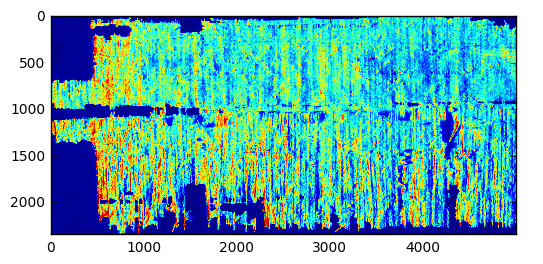

In [4]:
# Read the blue wave-length image and show it
blue = read_and_crop("sliced/PX303-Fg001-V-C01-R01-D05032015-T112722-MLIR__026.jpg") 

# Show the relevant image
plt.imshow(blue)

cubes, cols, rows = slice_to_static_slices(blue)

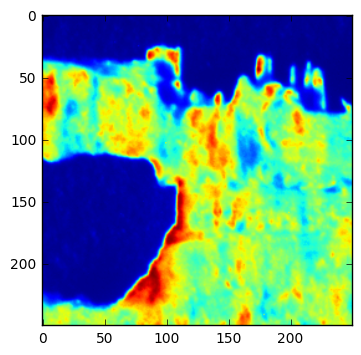

In [5]:
# TESTING

# len(cubes)
a = cubes[(0,3)]
plt.imshow(a["cube"])
# plt.imshow(cubes[(0,3)]["cube"])
# np.median(cubes[(0,3)])
# plt.imshow(np.concatenate((cubes[(0,3)]["cube"], cubes[(0,4)]["cube"]), axis=1))
# cols, rows


# print(cubes[(0,3)]["cube"][249][:10])
# print(cubes[(0,3)]["cube"][248][:10])
# print(cubes[(0,3)]["cube"][247][:10])
# print(cubes[(0,3)]["cube"][246][:10])
# print(cubes[(0,3)]["cube"][245][:10])
# indices = np.zeros(5)
# a=np.insert(cubes[(1,3)]["cube"], indices, cubes[(0,3)]["cube"][-5:], axis=0)
# print(a[4][:10])
# print(a[3][:10])
# print(a[2][:10])
# print(a[1][:10])
# print(a[0][:10])
# print(a.shape)
# b = np.delete(a, np.arange(250,255), axis=0)
# print(b.shape)



# original = cubes[(0,3)]["cube"]
# below = cubes[(1,3)]["cube"]
# amount = 5
# print(below[0][:10])
# print(below[1][:10])
# print(below[2][:10])
# print(below[3][:10])
# print(below[4][:10])

# pad_below(original, below, 5)

# print(res[245][:10])
# print(res[246][:10])
# print(res[247][:10])
# print(res[248][:10])
# print(res[249][:10])

# print(res.shape)




# TODO:
# 1/ ignore semi-dark cubes? or let them be...
# save a struct for each cube with the meta data of neighbors
# run the fingerprint algorithm for each cube and attach to meta data struct
# run a training algorithm aimed at minimizing the errors of identifying the neighbors
# might need to run first horizontal and then vertical


In [6]:
# Build the images list corresponding the the labels list
warnings.filterwarnings("ignore")

train_imgs = []
train_lbls = []
for row in range(0, rows):
    for col in range(0, cols):
        if (cubes[(row, col)] != None):
            curr = cubes[(row, col)]
            for adj_row in range(0, rows):
                for adj_col in range(0, cols):
                    if (adj_row != row or adj_col != col):
                        if (cubes[(adj_row, adj_col)] != None):
                            adj = cubes[(adj_row, adj_col)]
                            train_imgs.append(np.concatenate((curr["cube"], adj["cube"]), axis=1)) 
                            if (adj_row == row and adj_col == (col + 1)):
                                train_lbls.append([0,1])
                                if ("top" in curr.keys() and "top"in adj.keys()):
                                    for i in range(5, 101, 5):
                                        curr1 = pad_above(curr["cube"], curr["top"]["cube"],i)
                                        adj1 = pad_above(adj["cube"], adj["top"]["cube"],i)
                                        train_imgs.append(np.concatenate((curr1, adj1), axis=1)) 
                                        train_lbls.append([0,1])
                                if ("bottom" in curr.keys() and "bottom"in adj.keys()):
                                    for i in range(5, 101, 5):
                                        curr1 = pad_below(curr["cube"], curr["bottom"]["cube"],i)
                                        adj1 = pad_below(adj["cube"], adj["bottom"]["cube"],i)
                                        train_imgs.append(np.concatenate((curr1, adj1), axis=1)) 
                                        train_lbls.append([0,1])
                            else:
                                train_lbls.append([1,0])
warnings.filterwarnings("default")
len(train_imgs)

27690

In [7]:
# split the original set randomly into a test set
from random import randrange

test_imgs = []
test_lbls = []
len_test = int(len(train_imgs) / 10)
for _ in range(0, len_test):
        random_index = randrange(0,len(train_imgs))
        test_imgs.append(train_imgs.pop(random_index))
        test_lbls.append(train_lbls.pop(random_index))

# train_set = DataSet(np.array(train_imgs), np.array(train_lbls))     
len(test_imgs)

2769

In [8]:
# Define util functions

# initialize a shaped matrix of weights with random values
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

# initialize a shaped matrix of bias with random values
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def max_pool_1x2(x):
  return tf.nn.max_pool(x, ksize=[1, 1, 2, 1],
                        strides=[1, 1, 2, 1], padding='SAME')

def max_pool_5x5(x):
  return tf.nn.max_pool(x, ksize=[1, 5, 5, 1],
                        strides=[1, 5, 5, 1], padding='SAME')


In [9]:
# Define the model

# foundation of the model - the input layer of the image 250x500=125000
x = tf.placeholder(tf.float32, [None, 250, 500])
x_image = tf.reshape(x, [-1,250,500,1]) # 1 is the number of color channels

# the target digits of the model
y_ = tf.placeholder(tf.float32, [None, 2])

# first convolutional layer: one input image and 32 output filters of 5x5
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1) # size is reduced to 125x250

# second convolutional layer: 32 input (filtered) images and 32 output filters of 5x5
W_conv2 = weight_variable([5, 5, 32, 32])
b_conv2 = bias_variable([32])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_1x2(h_conv2) # size is reduced to 125x125

# third convolutional layer: 32 input (filtered) images and 32 output filters of 5x5
W_conv3 = weight_variable([5, 5, 32, 32])
b_conv3 = bias_variable([32])
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_5x5(h_conv3) # size is reduced to 25x25


h_pool3_flat = tf.reshape(h_pool3, [-1, 25*25*32]) # shape as an array 

# fourth layer - fully connected with input 25*25*128 and output 1024
W_fc1 = weight_variable([25*25*32, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

# a drop layer with probability 
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# final layer - softmax reduction 2 outputs
W_fc2 = weight_variable([1024, 2])
b_fc2 = bias_variable([2])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# minimize loss function
cross_entropy = tf.reduce_mean(
  tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

# define train step and rate
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [ ]:
# Prepare the session

# create a saver object
saver = tf.train.Saver()

# start session and initialize variables
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

# evaluate the prediction and the accuracy on the train test - needed only for printing during the training
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



In [17]:
# Train the model
x_batch = []
y_batch = []
# run the train batches
for i in range(1000):
    x_batch = []
    y_batch = []
    for _ in range(10):
        random_index = randrange(0,len(train_imgs))
        x_batch.append(train_imgs[random_index])
        y_batch.append(train_lbls[random_index])
        
    # print the accuracy thus far
    if (i+1)%10 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:x_batch, y_: y_batch, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    # train
    train_step.run(feed_dict={x: x_batch, y_: y_batch, keep_prob: 0.5})
train_accuracy = accuracy.eval(feed_dict={
    x:x_batch, y_: y_batch, keep_prob: 1.0})
print("step %d, training accuracy %g"%(i, train_accuracy))

# Save the variables to disk.
save_path = saver.save(sess, "/tmp/model.ckpt")
print("Model saved in file: %s" % save_path)

step 9, training accuracy 1
step 19, training accuracy 0.9
step 29, training accuracy 1
step 39, training accuracy 1
step 49, training accuracy 1
step 59, training accuracy 1
step 69, training accuracy 1
step 79, training accuracy 0.9
step 89, training accuracy 0.8
step 99, training accuracy 0.9
step 109, training accuracy 1
step 119, training accuracy 1
step 129, training accuracy 1
step 139, training accuracy 1
step 149, training accuracy 0.8
step 159, training accuracy 1
step 169, training accuracy 1
step 179, training accuracy 0.9
step 189, training accuracy 1
step 199, training accuracy 1
step 209, training accuracy 1
step 219, training accuracy 1
step 229, training accuracy 1
step 239, training accuracy 0.9
step 249, training accuracy 1
step 259, training accuracy 1
step 269, training accuracy 1
step 279, training accuracy 1
step 289, training accuracy 1
step 299, training accuracy 0.8
step 309, training accuracy 1
step 319, training accuracy 1
step 329, training accuracy 1
step 

In [ ]:
# Test the model
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: test_imgs, y_: test_lbls, keep_prob: 1.0}))

In [18]:
# Test the model
for i in range(100):
    x_batch = []
    y_batch = []
    for j in range(20):
        x_batch.append(test_imgs[i*20+j])
        y_batch.append(test_lbls[i*20+j])

#     my_prediction=tf.argmax(y_conv,1)
#     my_target=tf.argmax(y_,1)
#     print(my_prediction.eval(feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0}))
#     print(my_target.eval(feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0}))

# print the accuracy thus far
    test_accuracy = accuracy.eval(feed_dict={
        x:x_batch, y_: y_batch, keep_prob: 1.0})
    if (i+1)%10 == 0:
        print("step %d, training accuracy %f"%(i, test_accuracy))

step 9, training accuracy 1.000000
step 19, training accuracy 1.000000
step 29, training accuracy 1.000000
step 39, training accuracy 1.000000
step 49, training accuracy 1.000000
step 59, training accuracy 0.950000
step 69, training accuracy 1.000000
step 79, training accuracy 0.950000
step 89, training accuracy 1.000000
step 99, training accuracy 1.000000


In [19]:
# Test the model
for i in range(100):
    x_batch = []
    y_batch = []
    for j in range(20):
        x_batch.append(test_imgs[i*20+j])
        y_batch.append(test_lbls[i*20+j])

    my_prediction=tf.argmax(y_conv,1)
    my_target=tf.argmax(y_,1)
    print(my_prediction.eval(feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0}))
    print(my_target.eval(feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0}))

# print the accuracy thus far
#     test_accuracy = accuracy.eval(feed_dict={
#         x:x_batch, y_: y_batch, keep_prob: 1.0})
#     if (i+1)%10 == 0:
#         print("step %d, training accuracy %g"%(i, test_accuracy))

[1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0]
[1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0]
[0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0]
[0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0]
[0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0 1]
[0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0]
[0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0]
[0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0

KeyboardInterrupt: 

/Users/il239838/anaconda/envs/tensorflow/lib/python3.5/site-packages/PIL/Image.py:678: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/il239838/Downloads/private/Thesis/Papyrus/large/PX303-Fg006-V-C01-R01-D08032015-T120724-MLIR__026.jpg'>
  self.load()


3499 4999


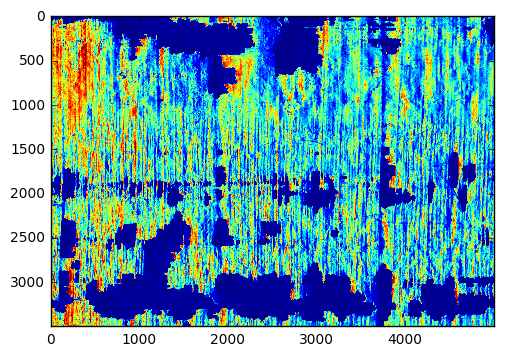

In [21]:
# Read the blue wave-length image and show it
blue = read_and_crop("large/PX303-Fg006-V-C01-R01-D08032015-T120724-MLIR__026.jpg") 

# Show the relevant image
plt.imshow(blue)

cubes, cols, rows = slice_to_static_slices(blue)

In [ ]:
train_imgs, train_lbls = build_train_set(rows, cols, cubes)